In [1]:
from sklearn.decomposition import IncrementalPCA
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy as sp

%matplotlib inline

#import os
#os.chdir('PCA_tests')

# Load dataset and set parameters
# Download data set (X.npz) here: https://drive.google.com/open?id=1eGp5TF9AoaHl6ugA5d3VoGYv_ZxDn_O9
X = np.load('X.npz')['arr_0']
N,P = X.shape
# Batch size
batch_size = 100
# Number of batches
B = int(N / batch_size)
# Number of principal components
n_components = 100

In [2]:
# Setup and run Incremental PCA on dataset
incpca = IncrementalPCA(n_components=n_components)
for b in range(B):
    incpca.partial_fit(X[b*batch_size:(b+1)*batch_size,:])

/home/gni021/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/incremental_pca.py:271: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/home/gni021/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [3]:
# Setup TensorFlow LAE model

# Hyper parameters
learning_rate = 0.001
reg_lambda = 0.01

# Parameters. Note: W2 is not explicitely declared as we will use W2=W1.T so we don't need to worry
# about symmetry.
W1 = tf.Variable(np.random.normal(size=(P, n_components)),dtype='float32')
b1 = tf.Variable(np.zeros(n_components),dtype='float32')
b2 = tf.Variable(np.zeros(P),dtype='float32')

# Input variable
X_ = tf.placeholder(shape=(None, P), dtype='float32')

# LAE Model
Xhat = tf.matmul(tf.matmul(X_, W1) + b1, tf.transpose(W1)) + b2

# Mean squared error cost function with L2 regularization on W1
cost = tf.losses.mean_squared_error(X_, Xhat) + \
       reg_lambda/2.0*tf.reduce_sum(tf.reduce_sum(tf.pow(W1, 2.0))) 

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
train_op = optimizer.minimize(cost)

# Initialize variables and run graph session
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [4]:
# Run TensorFlow LAE model
b, display_b = 0, 1000

In [5]:
# Run TensorFlow LAE model -- continued
iterations = 20000
while b < iterations:
    X_batch = X[b%B*batch_size:(b%B+1)*batch_size,:]
    sess.run(train_op, feed_dict={X_: X_batch})

    if b % display_b == 0:
        train_loss = sess.run(cost, feed_dict={X_: X_batch})           
        print("Step " + str(b) + ", Train Loss=" + "{:.8f}".format(train_loss))
                                    
    b = b + 1

Step 0, Train Loss=3200.68823242
Step 1000, Train Loss=1781.81298828
Step 2000, Train Loss=1085.35034180
Step 3000, Train Loss=610.40808105
Step 4000, Train Loss=328.17224121
Step 5000, Train Loss=152.37971497
Step 6000, Train Loss=62.15480042
Step 7000, Train Loss=25.63860130
Step 8000, Train Loss=10.44163227
Step 9000, Train Loss=3.84741735
Step 10000, Train Loss=1.17690706
Step 11000, Train Loss=0.27002853
Step 12000, Train Loss=0.04413248
Step 13000, Train Loss=0.01208330
Step 14000, Train Loss=0.00682024
Step 15000, Train Loss=0.00176519
Step 16000, Train Loss=0.00763900
Step 17000, Train Loss=0.00635960
Step 18000, Train Loss=0.00173319
Step 19000, Train Loss=0.00763843


In [6]:
# Calculate the mean and first two principal components from LAE (PCA)
u,s,v = sp.linalg.svd(sess.run(W1), full_matrices=False)
laepca_components = np.transpose(u)
laepca_mean = sess.run(b2)

Text(0.5,0.98,'LAE PCA')

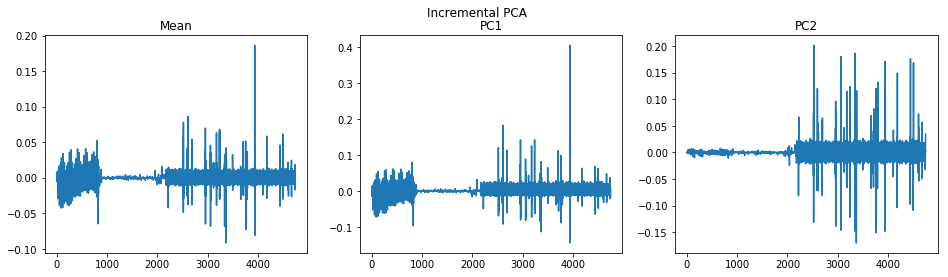

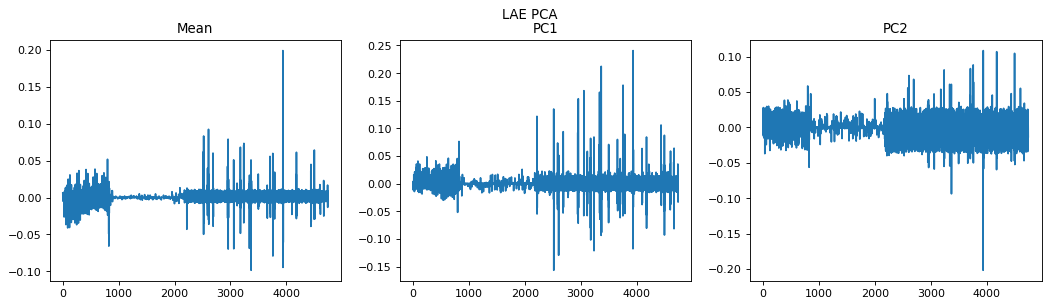

In [7]:
# Plot the mean and first two principal components from Incremental PCA
fig0 = plt.figure(figsize=(16, 4))
ax1 = fig0.add_subplot(1, 3, 1)
ax2 = fig0.add_subplot(1, 3, 2)
ax3 = fig0.add_subplot(1, 3, 3)

ax1.plot(incpca.mean_)
ax1.set_title('Mean')
ax2.plot(incpca.components_[0,:])
ax2.set_title('PC1')
ax3.plot(incpca.components_[1,:])
ax3.set_title('PC2')
fig0.suptitle('Incremental PCA')

# Plot the mean and first two principal components from LAE PCA
fig1 = plt.figure(figsize=(16, 4), dpi=80)
ax1 = fig1.add_subplot(1, 3, 1)
ax2 = fig1.add_subplot(1, 3, 2)
ax3 = fig1.add_subplot(1, 3, 3)

ax1.plot(laepca_mean)
ax1.set_title('Mean')
ax2.plot(laepca_components[0,:])
ax2.set_title('PC1')
ax3.plot(laepca_components[1,:])
ax3.set_title('PC2')
fig1.suptitle('LAE PCA')
